Using 2 GPU(s)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Found 985 files to load.
Dataset built: X=(106380, 70200), Y=(106380, 23400)
Saved new data splits to data_splits.npz
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Starting new training run
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflo

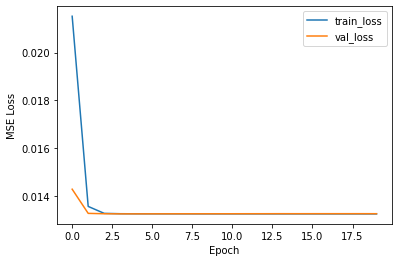

998/998 [==============================] - 2s 2ms/step - loss: 0.0133 - correlation_metric: 0.1689 - mse: 0.0133
Test Loss: 0.0133, Test MSE: 0.0133, Test Corr: 0.1689


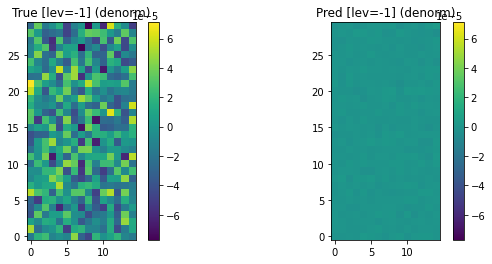

In [2]:
import glob
import os
import random
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Enable GPU memory growth on all GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Using {len(gpus)} GPU(s)")
else:
    print("No GPUs found, using CPU.")

# Use MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

# Pearson correlation metric for Keras
def correlation_metric(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    mean_true = tf.reduce_mean(y_true_flat)
    mean_pred = tf.reduce_mean(y_pred_flat)
    cov = tf.reduce_mean((y_true_flat - mean_true) * (y_pred_flat - mean_pred))
    std_true = tf.sqrt(tf.reduce_mean(tf.square(y_true_flat - mean_true)))
    std_pred = tf.sqrt(tf.reduce_mean(tf.square(y_pred_flat - mean_pred)))
    return cov / (std_true * std_pred + tf.keras.backend.epsilon())

class ChunkedLatLonDataset:
    """
    Reads GEOS outputs, reshapes, chunks, adds spatial coords, and
    applies block-wise min-max normalization to features and targets.
    """
    def __init__(self, file_pattern, in_var, tgt_var, chunk_fy=30, chunk_x=15):
        files = glob.glob(file_pattern)
        print(f"Found {len(files)} files to load.")
        ds = xr.open_mfdataset(files, combine='by_coords')
        arr_in = ds[in_var].values.astype('float32')
        arr_tgt = ds[tgt_var].values.astype('float32')

        # Unpack dimensions
        t, lev, face, ny, nx = arr_in.shape
        self.lev = lev
        fy = face * ny
        # reshape face & latitude dims
        arr_in = arr_in.reshape(t, lev, fy, nx)
        arr_tgt = arr_tgt.reshape(t, lev, fy, nx)

        # build normalized spatial coordinate grids
        fy_idx = np.linspace(0, 1, fy, dtype='float32')
        x_idx  = np.linspace(0, 1, nx, dtype='float32')
        coord_fy, coord_x = np.meshgrid(fy_idx, x_idx, indexing='ij')

        data_list, target_list = [], []
        for ti in range(t):
            for yi in range(0, fy, chunk_fy):
                for xi in range(0, nx, chunk_x):
                    block_in  = arr_in[ti, :, yi:yi+chunk_fy, xi:xi+chunk_x]
                    block_tgt = arr_tgt[ti, :, yi:yi+chunk_fy, xi:xi+chunk_x]
                    cf = coord_fy[yi:yi+chunk_fy, xi:xi+chunk_x]
                    cx = coord_x[yi:yi+chunk_fy, xi:xi+chunk_x]
                    # flatten and concatenate
                    flat_in = block_in.reshape(-1)
                    cf_flat = np.repeat(cf, lev)
                    cx_flat = np.repeat(cx, lev)
                    features = np.concatenate([flat_in, cf_flat, cx_flat])
                    targets  = block_tgt.reshape(-1)
                    data_list.append(features)
                    target_list.append(targets)

        # stack into arrays
        X = np.stack(data_list)
        Y = np.stack(target_list)
        print(f"Dataset built: X={X.shape}, Y={Y.shape}")

        # determine block sizes
        d = lev * chunk_fy * chunk_x
        # split feature blocks
        X_dt = X[:, :d]
        X_cf = X[:, d:2*d]
        X_cx = X[:, 2*d:3*d]

        # compute min/max for each block separately
        self.X_dt_min, self.X_dt_max = X_dt.min(axis=0), X_dt.max(axis=0)
        self.X_cf_min, self.X_cf_max = X_cf.min(axis=0), X_cf.max(axis=0)
        self.X_cx_min, self.X_cx_max = X_cx.min(axis=0), X_cx.max(axis=0)
        self.Y_min, self.Y_max     = Y.min(axis=0), Y.max(axis=0)

        # normalize each block and target
        X_dt_n = (X_dt - self.X_dt_min) / (self.X_dt_max - self.X_dt_min + 1e-8)
        X_cf_n = (X_cf - self.X_cf_min) / (self.X_cf_max - self.X_cf_min + 1e-8)
        X_cx_n = (X_cx - self.X_cx_min) / (self.X_cx_max - self.X_cx_min + 1e-8)
        self.X = np.concatenate([X_dt_n, X_cf_n, X_cx_n], axis=1).astype('float32')
        self.Y = ((Y - self.Y_min) / (self.Y_max - self.Y_min + 1e-8)).astype('float32')

if __name__ == '__main__':
    random.seed(0)
    chunk_fy, chunk_x = 30, 15
    dataset = ChunkedLatLonDataset(
        '/home/afahad/nb/subgrid_tend/6km/Ttrain_*.nc4',
        'dT', 'subT', chunk_fy=chunk_fy, chunk_x=chunk_x
    )

    # split train/val/test, reuse if exists
    split_file = 'data_splits.npz'
    if os.path.exists(split_file):
        splits = np.load(split_file)
        train_idx, val_idx, test_idx = splits['train_idx'], splits['val_idx'], splits['test_idx']
        print("Loaded existing data splits from", split_file)
    else:
        n = dataset.X.shape[0]
        indices = np.arange(n)
        np.random.shuffle(indices)
        t1, t2 = int(0.7*n), int(0.85*n)
        train_idx, val_idx, test_idx = indices[:t1], indices[t1:t2], indices[t2:]
        np.savez(split_file, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)
        print("Saved new data splits to", split_file)

    X_train, Y_train = dataset.X[train_idx], dataset.Y[train_idx]
    X_val,   Y_val   = dataset.X[val_idx],   dataset.Y[val_idx]
    X_test,  Y_test  = dataset.X[test_idx],  dataset.Y[test_idx]

    # prepare datasets
    batch_size = 16
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    # create and compile model inside strategy scope
    with strategy.scope():
        dim_in  = X_train.shape[1]
        dim_out = Y_train.shape[1]
        model = models.Sequential([
            layers.Input(shape=(dim_in,)),
            layers.Dense(512, activation='relu'), layers.BatchNormalization(), layers.Dropout(0.3),
            layers.Dense(256, activation='relu'), layers.BatchNormalization(), layers.Dropout(0.3),
            layers.Dense(dim_out)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mse', correlation_metric])

    model_file = 'keras_subgrid.h5'
    if os.path.exists(model_file):
        model.load_weights(model_file)
        print("Resuming training from saved model", model_file)
    else:
        print("Starting new training run")

    # checkpoint callback
    ckpt_cb = callbacks.ModelCheckpoint(model_file, save_best_only=True, monitor='val_mse', mode='min')

    # train model
    ehistory = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[ckpt_cb]
    )

    # plot train vs val loss
    plt.figure()
    plt.plot(ehistory.history['loss'], label='train_loss')
    plt.plot(ehistory.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # test evaluation
    results = model.evaluate(X_test, Y_test, batch_size=batch_size)
    test_loss, test_mse, test_corr = results[0], results[1], results[2]
    print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test Corr: {test_corr:.4f}")

    # plot one test sample with de-normalization
    i = random.choice(test_idx)
    y_true_norm = Y_test[list(test_idx).index(i)]
    y_true = (y_true_norm * (dataset.Y_max - dataset.Y_min) + dataset.Y_min).reshape(dataset.lev, chunk_fy, chunk_x)
    y_pred_norm = model.predict(dataset.X[i:i+1])[0]
    y_pred = (y_pred_norm * (dataset.Y_max - dataset.Y_min) + dataset.Y_min).reshape(dataset.lev, chunk_fy, chunk_x)

    plt.figure(figsize=(10,4))
    vmin = min(y_true[-1].min(), y_pred[-1].min())
    vmax = max(y_true[-1].max(), y_pred[-1].max())
    plt.subplot(1,2,1)
    plt.title('True [lev=-1] (denorm)')
    plt.imshow(y_true[-1], origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title('Pred [lev=-1] (denorm)')
    plt.imshow(y_pred[-1], origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()